# Aprendizaje supervizado: clasificación
## K vecinos más cercanos (k-NN)

## Librerías

In [2]:
!pip install feature-engine

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 378.6/378.6 kB 8.8 MB/s eta 0:00:00


In [3]:
# Análisis exploratorio
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Preparación de los datos
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from feature_engine.outliers import Winsorizer # remoción de outliers


# Clasificador KNN
from sklearn.neighbors import KNeighborsClassifier

# Métricas
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, classification_report,
                             ConfusionMatrixDisplay)

## Base de datos: análisis de casos de infarto de miocardio

### Atributos
* Age: edad del peciente (años)
* Sex: sexo del paciente (M: Masculino, F: Femenino)
* ChestPainType: tipo de dolor en el pecho:
  * TA: Angina típica
  * ATA: Angina atípica
  * NAP: Dolor no aginal
  * ASY: Asintomático
* RestingBP: presión arterial en reposo (mmHg)
* Cholesterol: colesterol sérico (mm/dl)
* FastingBS: glucemia en ayunas:
  * 1: si FastingBS > 120 mg/dl
  * 0: si no
* RestingECG: resultados del electrocardiograma en reposo:
  * Normal: Normal
  * ST: tener anomalía de la onda ST-T (inversiones de la onda T y/o elevación o depresión del ST > 0,05 mV)
  * LVH: que muestra hipertrofia ventricular izquierda probable o definitiva según los criterios de Estes
* MaxHR: frecuencia cardíaca máxima alcanzada (valor numérico entre 60 y 202)
* ExerciseAngina: angina inducida por el ejercicio (Y: Si, N: No)
* Oldpeak: pico previo.
* ST_Slope: la pendiente del segmento ST del ejercicio máximo:
  * Up: upsloping
  * Flat: flat
  * Down: downsloping

In [4]:
!gdown 1Q00pSYZdljWCf3eQ_oS8I2AHGsl2y_1C

Downloading...
From: https://drive.google.com/uc?id=1Q00pSYZdljWCf3eQ_oS8I2AHGsl2y_1C
To: /content/heart.csv
100% 35.9k/35.9k [00:00<00:00, 51.0MB/s]


In [5]:
df = pd.read_csv("heart.csv")

### Estructura

In [6]:
df.head(10)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
5,39,M,NAP,120,339,0,Normal,170,N,0.0,Up,0
6,45,F,ATA,130,237,0,Normal,170,N,0.0,Up,0
7,54,M,ATA,110,208,0,Normal,142,N,0.0,Up,0
8,37,M,ASY,140,207,0,Normal,130,Y,1.5,Flat,1
9,48,F,ATA,120,284,0,Normal,120,N,0.0,Up,0


In [7]:
# Obtener información general sobre el DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [8]:
# Obtener estadísticas descriptivas
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [9]:
df["HeartDisease"].value_counts()

,count
HeartDisease,
1,508
0,410


## División train-test

In [37]:
# Separo variable objetivo de datos
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']

In [38]:
# Obtengo datos de entrenamiento y de testeo
Xtrn, Xtst, ytrn, ytst  = train_test_split(X, y, test_size=0.2,
                            random_state=13, shuffle=True, stratify=y)

## Análisis exploratorio

In [12]:
ytrn.value_counts()

,count
HeartDisease,
1,406
0,328


### Correlación de atributos

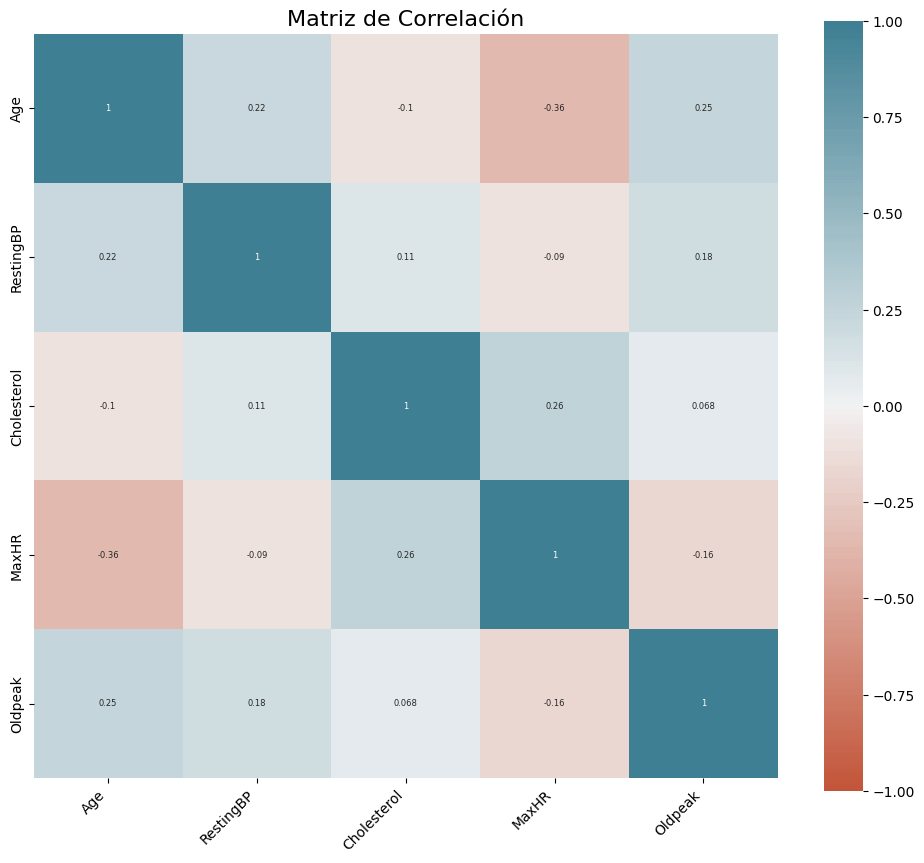

In [13]:
num_cols = df.columns[[0, 3, 4, 7, 9]]
plt.figure(figsize=(12, 10))
corr = Xtrn[num_cols].corr(method='pearson')
ax = sns.heatmap(
    corr,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot = True,
    annot_kws = {'size': 6}
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
plt.title('Matriz de Correlación', fontsize=16)
plt.show()

### Distribución de atributos

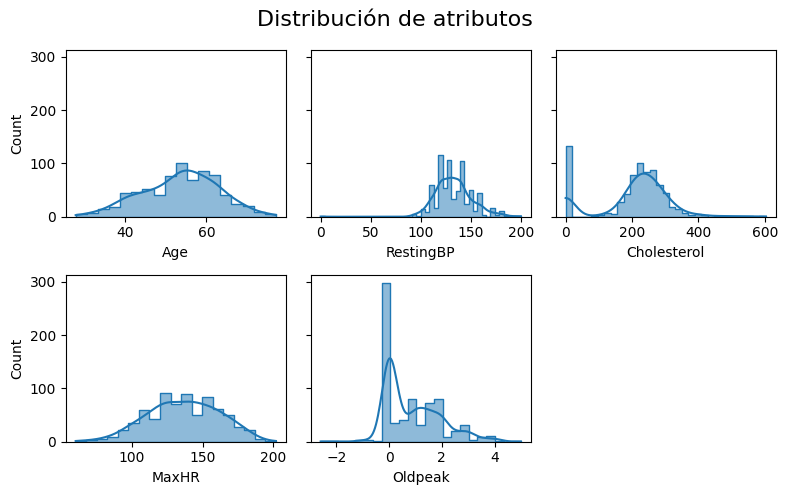

In [14]:
r = 2
c = 3
fig, axes = plt.subplots(nrows=r, ncols=c, sharey=True,
                         figsize=(8, 5))
for i, col in enumerate(num_cols, 1):
    sns.histplot(data=Xtrn, x=col, kde=True, element='step',
                 ax=axes.flatten()[i-1])

for i in range(len(num_cols)+1, (r*c)+1):
    axes.flatten()[i-1].axis('off')

plt.suptitle('Distribución de atributos', fontsize=16)
plt.tight_layout()
plt.show()

## Preparación de los datos

### Conversión de categóricas

In [39]:
# Convertir columnas categóricas en numéricas
cat_cols = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
cat_labels = [Xtrn[col].unique().tolist() for col in cat_cols]
enc = OrdinalEncoder(categories=cat_labels).set_output(transform="pandas")
enc.fit(Xtrn[cat_cols])
Xtrn[cat_cols] = enc.transform(Xtrn[cat_cols])

# Mostrar el DataFrame después de la transformación
Xtrn.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
319,68,0.0,0.0,145,0,1,0.0,136,0.0,1.8,0.0
735,49,0.0,1.0,120,188,0,0.0,139,0.0,2.0,1.0
273,55,0.0,1.0,120,220,0,1.0,134,0.0,0.0,0.0
410,62,0.0,0.0,150,0,1,2.0,78,0.0,2.0,1.0
297,57,0.0,0.0,110,0,1,2.0,131,1.0,1.4,0.0


In [16]:
enc.categories_

[array(['M', 'F'], dtype=object),
 array(['ASY', 'NAP', 'ATA', 'TA'], dtype=object),
 array(['Normal', 'LVH', 'ST'], dtype=object),
 array(['N', 'Y'], dtype=object),
 array(['Up', 'Flat', 'Down'], dtype=object)]

In [17]:
enc.inverse_transform(Xtrn[cat_cols])

array([['M', 'ASY', 'Normal', 'N', 'Up'],
       ['M', 'NAP', 'Normal', 'N', 'Flat'],
       ['M', 'NAP', 'LVH', 'N', 'Up'],
       ...,
       ['M', 'NAP', 'LVH', 'N', 'Flat'],
       ['M', 'ATA', 'Normal', 'N', 'Up'],
       ['M', 'ASY', 'Normal', 'Y', 'Flat']], dtype=object)

### Valores atípicos


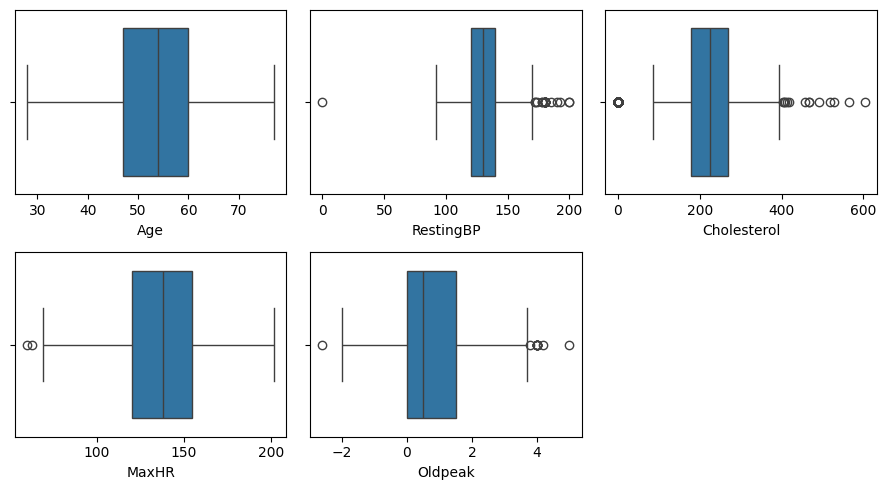

In [40]:
r = 2
c = 3
fig, axes = plt.subplots(nrows=r, ncols=c, sharey=False,
                         figsize=(9, 5))
for i, col in enumerate(num_cols, 1):
    sns.boxplot(data=Xtrn, x=col, ax=axes.flatten()[i-1])

for i in range(len(num_cols)+1, (r*c)+1):
    axes.flatten()[i-1].axis('off')

plt.tight_layout()
plt.show()

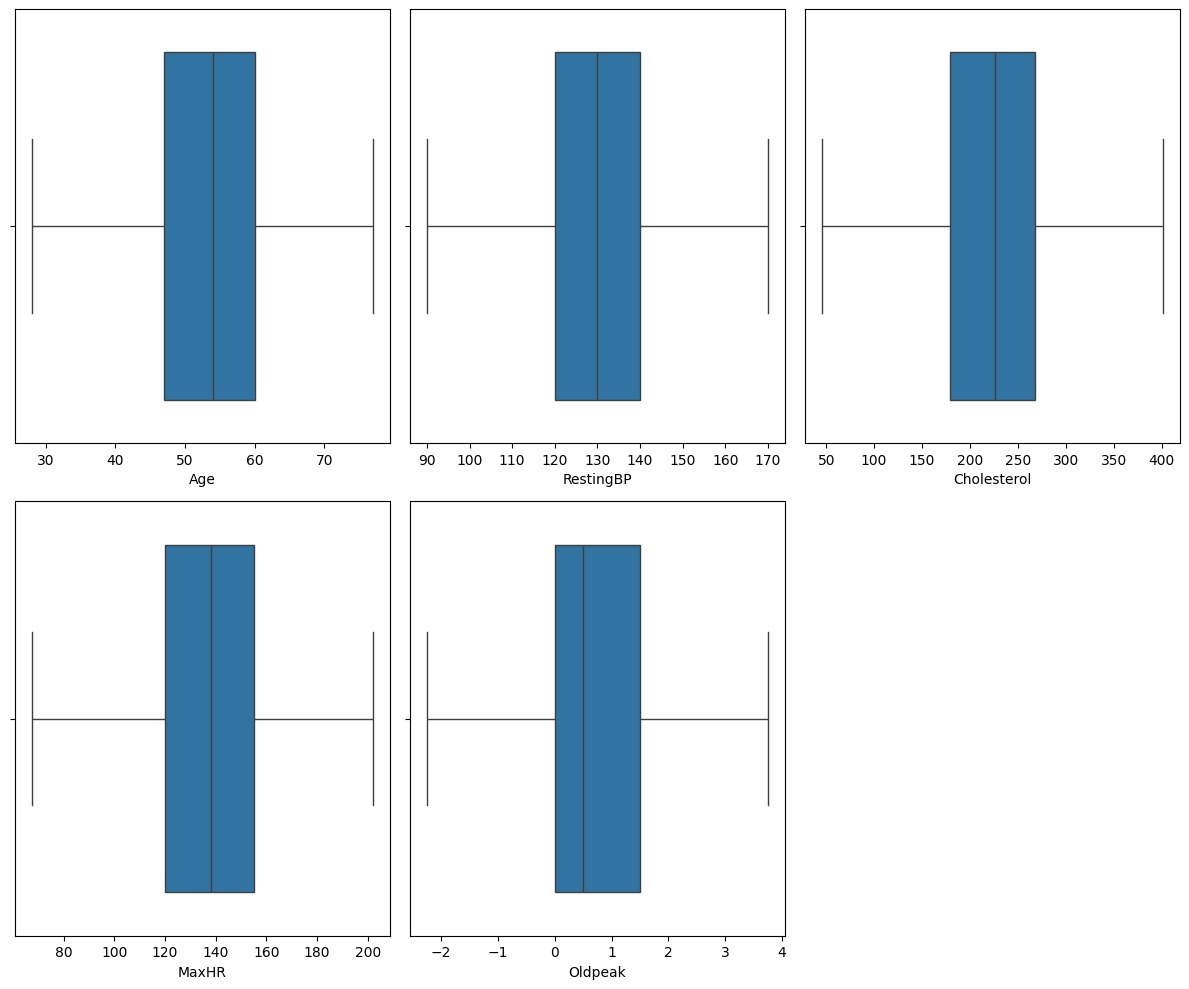

In [41]:
clean = num_cols[1:]
X_clean = Xtrn.copy()
winsor = Winsorizer(capping_method='iqr', tail='both',fold=1.5)
X_clean[clean] = winsor.fit_transform(X_clean[clean])

fig, axes = plt.subplots(nrows=r, ncols=c, sharey=False,
                         figsize=(12, 10))
for i, col in enumerate(num_cols, 1):
    sns.boxplot(data=X_clean, x=col, ax=axes.flatten()[i-1])

for i in range(len(num_cols)+1, (r*c)+1):
    axes.flatten()[i-1].axis('off')

plt.tight_layout()
plt.show()

### Escalado

In [42]:
scaler = StandardScaler().set_output(transform="pandas")
scaler.fit(X_clean[num_cols])
Xtrn[num_cols] = scaler.transform(X_clean[num_cols])
Xtst[num_cols] = scaler.transform(Xtst[num_cols])

## Clasificador
https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

In [44]:
# Inicializar el clasificador KNN (K=3 en este caso)
knn = KNeighborsClassifier(n_neighbors=3)
# Entrenar el modelo
knn.fit(Xtrn, ytrn)

KNeighborsClassifier(n_neighbors=3)

In [46]:
# Realizar predicciones en el conjunto de prueba
Xtst[cat_cols] = enc.transform(Xtst[cat_cols])
predictions = knn.predict(Xtst)

Precisión del modelo: 0.81

Informe de Clasificación:
              precision    recall  f1-score   support

           0       0.76      0.83      0.80        82
           1       0.85      0.79      0.82       102

    accuracy                           0.81       184
   macro avg       0.81      0.81      0.81       184
weighted avg       0.81      0.81      0.81       184



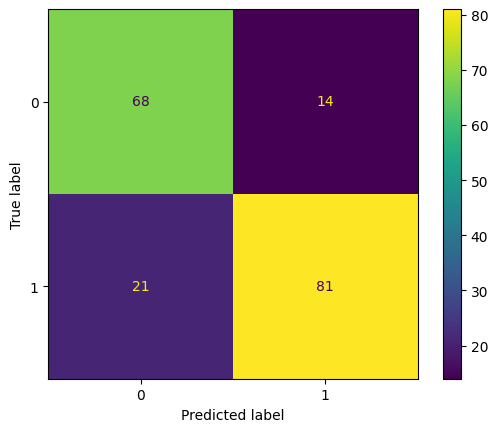

In [47]:
cm_knn = confusion_matrix(ytst, predictions)
ConfusionMatrixDisplay(confusion_matrix=cm_knn).plot()

# Calcular la precisión del modelo
accuracy = accuracy_score(ytst, predictions)
print(f'Precisión del modelo: {accuracy:.2f}')

# Mostrar el informe de clasificación
print('\nInforme de Clasificación:')
print(classification_report(ytst, predictions))

## Grilla de búsqueda con validación cruzada

In [51]:
# Definir los parámetros a ajustar
parametros_grid = {'n_neighbors':  range(1, 50, 10),
                   'p':[1,2],
                   'weights': ['uniform', 'distance'] }

# Inicializar el objeto GridSearchCV
grid_search = GridSearchCV(estimator = knn,
                           param_grid = parametros_grid,
                           cv=5,
                           scoring='accuracy')

In [52]:
# Realizar la búsqueda de hiperparámetros en el conjunto de entrenamiento
grid_search.fit(Xtrn, ytrn)

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:", grid_search.best_params_)

# Obtener el mejor modelo entrenado
mejor_clasificador = grid_search.best_estimator_

Mejores hiperparámetros: {'n_neighbors': 21, 'p': 1, 'weights': 'uniform'}


Precisión del modelo: 0.84

Informe de Clasificación:
              precision    recall  f1-score   support

           0       0.81      0.84      0.83        82
           1       0.87      0.84      0.86       102

    accuracy                           0.84       184
   macro avg       0.84      0.84      0.84       184
weighted avg       0.84      0.84      0.84       184



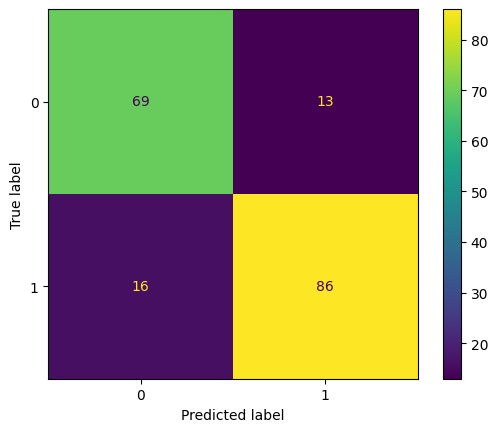

In [54]:
# Realizar predicciones en el conjunto de prueba
pred = mejor_clasificador.predict(Xtst)

cm_knn = confusion_matrix(ytst, pred)
ConfusionMatrixDisplay(confusion_matrix=cm_knn).plot()

accuracy = accuracy_score(ytst, pred)
print(f'Precisión del modelo: {accuracy:.2f}')

# Mostrar el informe de clasificación
print('\nInforme de Clasificación:')
print(classification_report(ytst, pred))